# EpsilonGreedyの考え方をコイントス実験を用いて確認する
  
## <コイントスゲーム>
* 表面が出る確率の異なるコインを何枚か用意する
* それらの中から1枚を選んで投げ、表面が出れば報酬をもらえる
* 報酬の合計を最大化するには、表面がでる確率が高いコインを「探索」によりなるべく早く見つけて、「活用」によりたくさん投げることが重要

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
class EnvironmentCoinToss():
    """
    コイントス実験用の環境のクラス
    """
    def __init__(self, head_probs, max_toss_num=30):
        """
        head_probs :  list, コインの表面が出る確率を格納したリスト
        max_toss_num : int, コインを投げる回数
        """
        # コインの表面が出る確率を格納したリスト
        self.head_probs = head_probs

        # コインの個数
        self.coin_num = len(self.head_probs)
        
        # コインを投げる回数
        self.max_toss_num = max_toss_num
        
        # コインを投げた回数
        self.toss_count = 0

    def reset(self):
        """
        コインを投げた回数をリセットするメソッド
        """
        self.toss_count = 0

    def step(self, action):
        """
        あるコインを投げた時(action)の報酬(reward)を返すメソッド
        action : int, 選択されたコインのインデックス
        """
        final = self.max_toss_num - 1

        # 終了判定
        done = True if self.toss_count == final else False

        # 選択されたコインの表面が出る確率
        head_prob = self.head_probs[action]
        
        # コインを投げる
        if random.random() < head_prob:
            """
            表面が出た場合
            """
            reward = 1.0
        else:
            """
            裏面が出た場合
            """
            reward = 0.0
            
        # 投げた回数をカウントする
        self.toss_count += 1
        
        return reward, done


class EpsilonGreedyAgent():
    """
    EpsilonGreedyによってコイントスゲームを進めていくエージェントのクラス
    """
    def __init__(self, epsilon):
        """
        epsilon : float, 探索を行う確率
        """
        self.epsilon = epsilon
        self.V = [] # 状態価値

    def policy(self):
        """
        次に投げるコインを決めるためのメソッド
        """
        # コインのインデックスをおさめた配列をつくる
        coins = range(len(self.V))
        
        # Epsilon Greedyによって、次に投げるコインを決定する
        if random.random() < self.epsilon:
            """
            探索
            """
            return random.choice(coins) # ランダムに選ぶ
        else:
            """
            活用
            """
            return np.argmax(self.V) # 価値が最も大きいものを選ぶ

    def play(self, env):
        """
        コインを所定の回数だけ投げるメソッド
        """
        
        # 初期化
        N = [0] * env.coin_num # 各コインが選択された回数を0で初期化する
        self.V = [0] * env.coin_num # 各コインの価値を0で初期化する
        
        # 前回の結果をリセットする
        env.reset()
        
        done = False
        rewards = []
        selected_coins = []
        while not done:
            """
            コインを所定の回数だけ投げる
            """
            # コインを選ぶ
            selected_coin = self.policy()
            selected_coins.append(selected_coin)
            
            # コインを投げる
            reward, done = env.step(selected_coin)
            rewards.append(reward)

            # 選択されたコインの価値を更新する
            n = N[selected_coin]
            coin_average = self.V[selected_coin] # 選択されたコインの現状の価値
            new_average = (coin_average * n + reward) / (n + 1) # 選択されたコインの更新後の価値
            self.V[selected_coin] = new_average # 価値の更新
            
            # 選択された回数を1進める
            N[selected_coin] += 1
            
        return rewards, selected_coins


## 実行

In [3]:
# 各コインの表面が出る確率を設定する
head_probs = [0.1, 0.5, 0.1, 0.9, 0.1] # コイン5個分

# 環境をつくる
env = EnvironmentCoinToss(head_probs)

# epsilonの条件を設定する
epsilons = [0.0, 0.1, 0.2, 0.5, 0.8]# 5パターン

# コインを投げる回数を設定する
toss_num= 50

dic_selected_coins = {}
dic_rewards = {}
for e in epsilons:
    """
    epsilonの違いを実験するためのループ
    """
    # エージェントをつくる
    agent = EpsilonGreedyAgent(epsilon=e)
    
    # コインを投げる回数をセット
    env.max_toss_num = toss_num

    # エージェントにコインを投げてもらう
    rewards, selected_coins = agent.play(env)
        
    # 結果を格納する
    dic_selected_coins["epsilon={}".format(e)] = selected_coins
    dic_rewards["epsilon={}".format(e)] = rewards
    


print("Rewards")
df_rewards = pd.DataFrame(dic_rewards)
display(df_rewards)

print()
print("Selected coin")
df_selected_conis = pd.DataFrame(dic_selected_coins)
display(df_selected_conis)

Rewards


,epsilon=0.0,epsilon=0.1,epsilon=0.2,epsilon=0.5,epsilon=0.8
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,1.0,0.0
6,1.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,1.0
8,1.0,1.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,0.0



Selected coin


,epsilon=0.0,epsilon=0.1,epsilon=0.2,epsilon=0.5,epsilon=0.8
0,0,0,0,0,3
1,0,0,0,0,4
2,0,0,0,3,0
3,0,0,0,3,1
4,0,0,0,4,4
5,0,0,0,3,1
6,0,0,0,3,4
7,0,0,0,1,3
8,0,1,0,3,4
9,0,1,0,4,1


## 結果の可視化

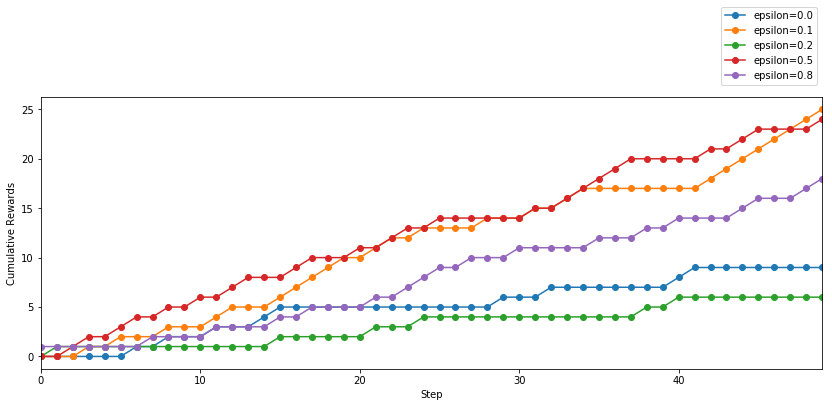

                                                                                                     step=投目




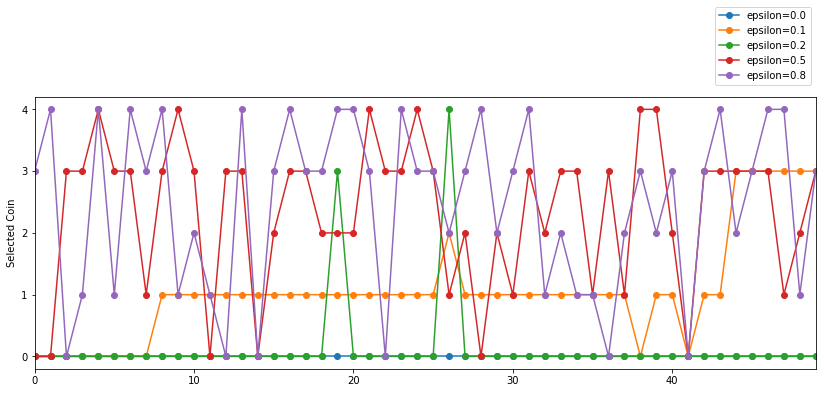

In [4]:
df_rewards.cumsum().plot.line(figsize=(14, 5), marker="o")
plt.ylabel("Cumulative Rewards")
plt.xlabel("Step")
# plt.legend(bbox_to_anchor=(1,1))
plt.legend(bbox_to_anchor=(1.0,1.35))
plt.show()
print(" "*100,"step=投目")
print()
print()

df_selected_conis.plot.line(figsize=(14, 5), marker="o")
plt.ylabel("Selected Coin")
plt.legend(bbox_to_anchor=(1.0,1.35))
plt.yticks(np.arange(0,5,1))
plt.show()
print()

* 試行のたびに結果は変わるが、epsilon=0.1~0.5の場合は、他のepsilonに比べ累積報酬が大きくなりやすい。
* epsilon=0.5, epsilon=0.8は、探索する機会が多いため、他のepsilonに比べいろんなコインを試している。